<a href="https://colab.research.google.com/github/nitish-pandey/Emotion-Analysis/blob/main/Emotion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import pandas as pd
import numpy as np
import os
import random
import re


import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data / Paragraph

In [2]:
train=pd.read_csv('/content/drive/MyDrive/My Codes and data/DataSets/NLP:Emotion/train.txt',sep=';',names=['Sentences','Emotion'])
test=pd.read_csv('/content/drive/MyDrive/My Codes and data/DataSets/NLP:Emotion/test.txt',sep=';',names=['Sentences','Emotion'])
val=pd.read_csv('/content/drive/MyDrive/My Codes and data/DataSets/NLP:Emotion/val.txt',sep=';',names=['Sentences','Emotion'])

In [3]:
print(train.head(),'\n\n',test.head(),'\n\n',val.head())

                                           Sentences  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger 

                                            Sentences  Emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness 

                                            Sentences  Emotion
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still looking at a blank canv...  sadness
2                     i feel like a faithful servant     love
3 

In [4]:
print("Training data : ",train.shape[0])
print("Testing data : ",test.shape[0])
print("Validation data : ",val.shape[0])

Training data :  16000
Testing data :  2000
Validation data :  2000


In [5]:
train.describe()

,Sentences,Emotion
count,16000,16000
unique,15969,6
top,i tend to stop breathing when i m feeling stre...,joy
freq,2,5362


In [6]:
train.drop_duplicates(inplace=True)
train.dropna(inplace=True)

In [7]:
train.groupby('Emotion').count()

,Sentences
Emotion,
anger,2159
fear,1937
joy,5361
love,1304
sadness,4666
surprise,572


#Data Cleaning

In [8]:
from nltk.corpus import stopwords
stoplist=stopwords.words('english')

from nltk.stem import WordNetLemmatizer

lemmatizer=WordNetLemmatizer()

In [9]:
def expand(phrase):
    
    phrase = re.sub(r"wont", "will not", phrase)
    phrase = re.sub(r"wouldnt", "would not", phrase)
    phrase = re.sub(r"shouldnt", "should not", phrase)
    phrase = re.sub(r"couldnt", "could not", phrase)
    phrase = re.sub(r"cudnt", "could not", phrase)
    phrase = re.sub(r"cant", "can not", phrase)
    phrase = re.sub(r"dont", "do not", phrase)
    phrase = re.sub(r"doesnt", "does not", phrase)
    phrase = re.sub(r"didnt", "did not", phrase)
    phrase = re.sub(r"wasnt", "was not", phrase)
    phrase = re.sub(r"werent", "were not", phrase)
    phrase = re.sub(r"havent", "have not", phrase)
    phrase = re.sub(r"hadnt", "had not", phrase)

    
    phrase = re.sub(r"n\ t", " not", phrase)
    phrase = re.sub(r"\re", " are", phrase)
    phrase = re.sub(r"\ s ", " is ", phrase) 
    phrase = re.sub(r"\ d ", " would ", phrase)
    phrase = re.sub(r"\ ll ", " will ", phrase)
    phrase = re.sub(r"\dunno", "do not ", phrase)
    phrase = re.sub(r"ive ", "i have ", phrase)
    phrase = re.sub(r"im ", "i am ", phrase)
    phrase = re.sub(r"i m ", "i am ", phrase)
    phrase = re.sub(r" w ", " with ", phrase)

    return phrase

In [10]:
def process(sentences):
    list=[]
    for i in range(len(sentences)):

        # Removing all characters except alphabets
        temp=re.sub('[^a-zA-Z]',' ',sentences[i])
        
        #Expanding the word ( like wont into will not )
        temp=expand(temp)

        #lowering all characters
        temp=temp.lower()
        #splitting the sentences into words
        temp=temp.split()

        # lamaetizing the only words which are not present in stopwords
        temp=[lemmatizer.lemmatize(word) for word in temp if word not in set(stoplist)]
    
        # joining the words into sentences
        temp=' '.join(temp)

        # Appending the new sentences into the new list which will be forward proceeded
        list.append(temp)
    return list

In [11]:
train['Sentences']=process(np.array(train['Sentences']))
test['Sentences']=process(np.array(test['Sentences']))
val['Sentences']=process(np.array(val['Sentences']))

In [12]:
emotion=np.array(train['Emotion'].unique())
dict={}
for i,e in enumerate(emotion):
    dict[e]=i

dict

{'anger': 1, 'fear': 4, 'joy': 5, 'love': 2, 'sadness': 0, 'surprise': 3}

In [13]:
train['Emotion']=train['Emotion'].replace(dict)
test['Emotion']=test['Emotion'].replace(dict)
val['Emotion']=val['Emotion'].replace(dict)

In [14]:
train.head()

,Sentences,Emotion
0,feel humiliated,0
1,go feeling hopeless damned hopeful around some...,0
2,grabbing minute post feel greedy wrong,1
3,ever feeling nostalgic fireplace know still no...,2
4,feeling grouchy,1


#Word Embedding

##TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_features=8000)
train_data=tfidf.fit_transform(train['Sentences'])
test_data=tfidf.transform(test['Sentences'])
val_data=tfidf.transform(val['Sentences'])



In [16]:
train_label=train.Emotion.values
test_label=test.Emotion.values
val_label=val.Emotion.values

# Machine Learning Implementation

In [17]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(max_iter=100000)

clf.fit(train_data,train_label)

pred=clf.predict(test_data)

In [18]:
from sklearn.metrics import classification_report ,confusion_matrix,accuracy_score
print('Accuracy : ',accuracy_score(test_label,pred))
print('\nConfusion Matrix : \n',confusion_matrix(test_label,pred))
print('\n\nClassification Report : ',classification_report(test_label,pred))

Accuracy :  0.868

Confusion Matrix : 
 [[539  14   1   1   4  22]
 [ 22 229   1   0   5  18]
 [  9   3  98   0   0  49]
 [  3   2   0  33  14  14]
 [ 23   9   1   1 176  14]
 [  7   4  18   2   3 661]]


Classification Report :                precision    recall  f1-score   support

           0       0.89      0.93      0.91       581
           1       0.88      0.83      0.85       275
           2       0.82      0.62      0.71       159
           3       0.89      0.50      0.64        66
           4       0.87      0.79      0.83       224
           5       0.85      0.95      0.90       695

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.81      2000
weighted avg       0.87      0.87      0.86      2000



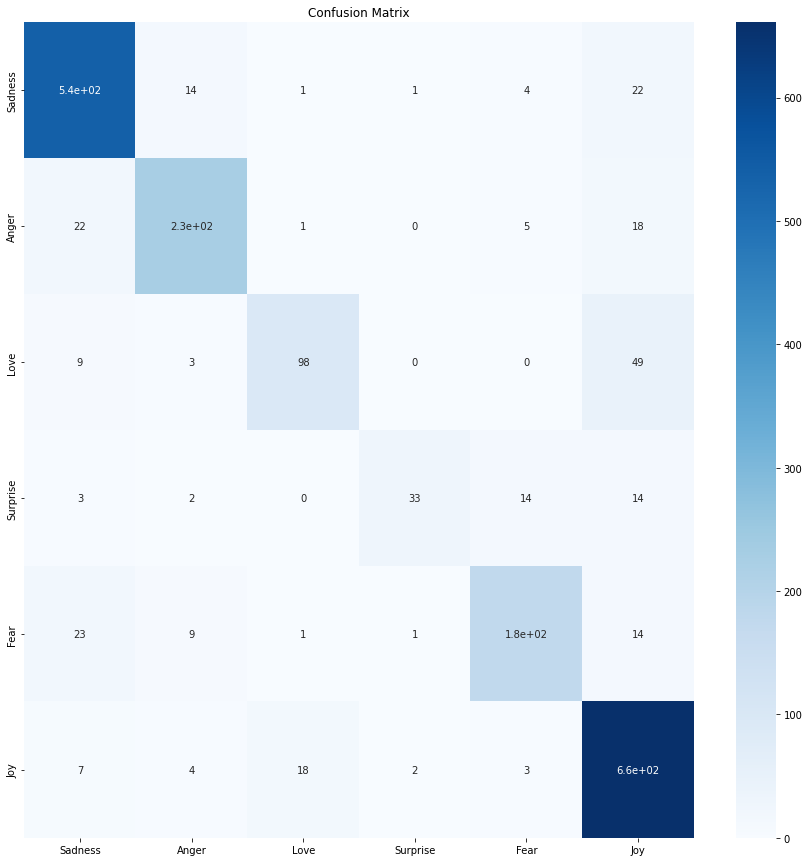

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
label=['Sadness','Anger','Love','Surprise','Fear','Joy']
matrix=confusion_matrix(test_label,pred)

matrix=pd.DataFrame(matrix,columns=label,index=label)
fig, ax = plt.subplots(figsize=(15,15))
ax.set(title='Confusion Matrix')

sns.heatmap(matrix,cmap='Blues',annot=True,ax=ax)

#Saving the model

In [20]:
import joblib

joblib.dump(clf,'mymodel.pkl')
joblib.dump(tfidf,'TF-IDF_vectorizer.pkl')

['TF-IDF_vectorizer.pkl']